In [6]:
library(monocle3)
library(Matrix)

load.python <- function(){
    X <- readMM(paste0(prefix,'.mtx'))

    cell_metadata <- read.csv(paste0(prefix,'-cell_metadata.csv'), stringsAsFactors = FALSE, row.names = 'index')
    gene_metadata <- read.csv(paste0(prefix,'-gene_metadata.csv'), stringsAsFactors = FALSE, row.names = 'index')

    X <- t(X)
    #rownames(gene) <- gene$ensembl_id
    rownames(X) <- rownames(gene_metadata)
    colnames(X) <- rownames(cell_metadata)
    gene_metadata$gene_short_name <- rownames(gene_metadata)
    
    cds <- new_cell_data_set(X,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_metadata) 
    saveRDS(cds, paste0(prefix,'-object-raw.rds'))
    
    cds
}


prefix <- 'paper-data/modelling/unt-rot-dan1-dan2'

#cds.raw <- load.python()

cds.raw <- readRDS('paper-data/modelling/objects/unt-rot-dan1-dan2/unt-rot-dan1-dan2-object-raw.rds')

colData(cds.raw)$case <- with(colData(cds.raw), paste0(treatment,'_',celltype))
colData(cds.raw)$id <- row.names(colData(cds.raw))


In [11]:
analyze.raw.regression <- function (cds)
{
        cds <- preprocess_cds(cds, num_dim = 15)
        plot_pc_variance_explained(cds)
        cds <- align_cds(cds, alignment_group = "treatment")
        print('Reducing dimensionality')
        cds <- reduce_dimension(cds)
        print('Clustering cells')
        cds <- cluster_cells(cds)
        cds <- learn_graph(cds)
        cds
}


analyze.raw <- function (cds){
        cds <- preprocess_cds(cds, num_dim = 15)
        plot_pc_variance_explained(cds)

        cds <- align_cds(cds, )
        print('Reducing dimensionality')
        cds <- reduce_dimension(cds)

        print('Clustering cells')
        cds <- cluster_cells(cds)

        cds <- learn_graph(cds)
        cds
}


In [8]:


cds <- analyze.raw.regression(cds.raw)

#cds <- order_cells(cds)

Aligning cells from different batches using Batchelor. 
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091



[1] "Reducing dimensionality"


No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



[1] "Clustering cells"
  |======================================================================| 100%
  |======================================================================| 100%


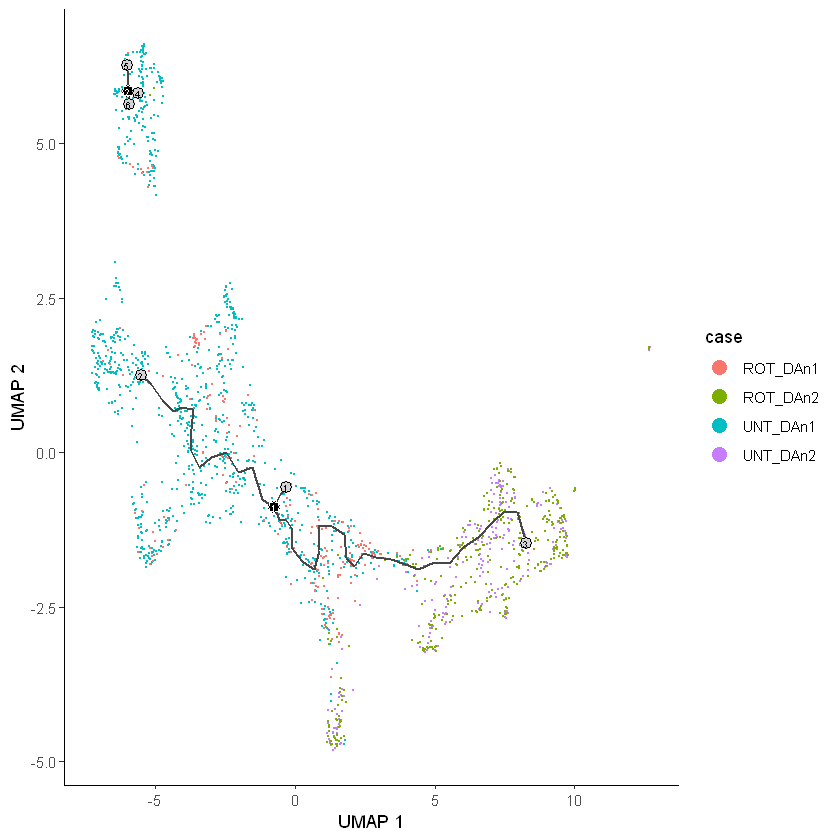

In [9]:
plot_cells(cds, color_cells_by = 'case', label_cell_groups=FALSE)


In [12]:

cds.unregressed <- analyze.raw(cds.raw)


[1] "Reducing dimensionality"


No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



[1] "Clustering cells"
  |======================================================================| 100%


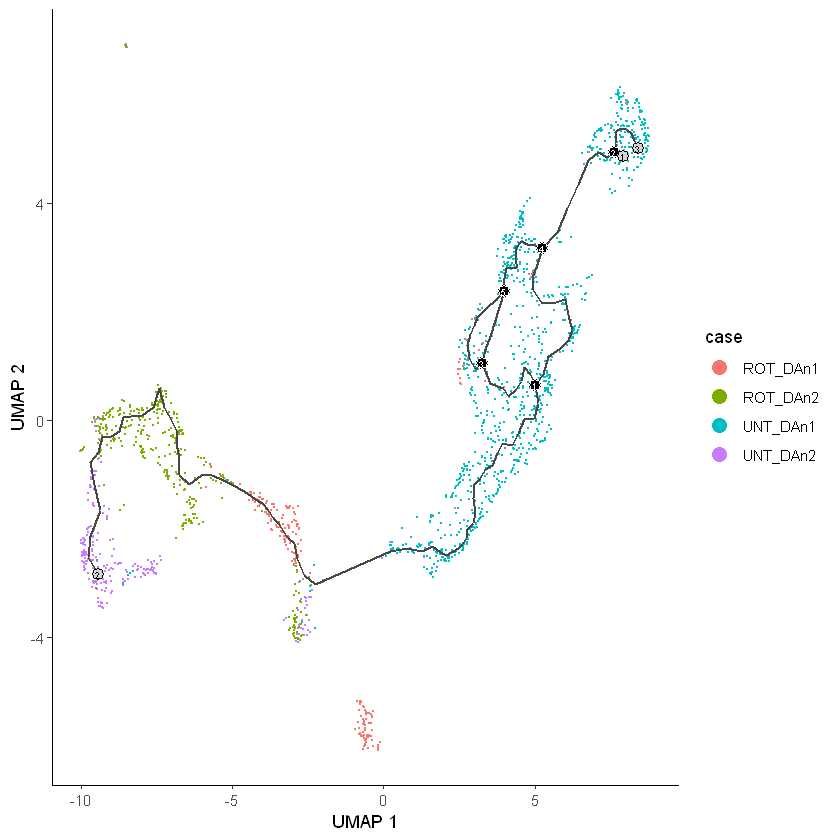

In [13]:
plot_cells(cds.unregressed, color_cells_by = 'case', label_cell_groups=FALSE)

In [14]:
#ciliated_cds_pr_test_res <- graph_test(cds, neighbor_graph="principal_graph", cores=1)
#saveRDS(ciliated_cds_pr_test_res,paste0(prefix,'_genes.rds'))
pr_graph_test_res <- readRDS(paste0(prefix,'_genes.rds'))

pr_deg_ids <- row.names(subset(pr_graph_test_res, q_value < 0.05))


#gene_module_df <- find_gene_modules(cds[pr_deg_ids,], resolution=1e-2)
gene_module_df <- readRDS(paste0(prefix,'-gene-modules.cds.rds'))




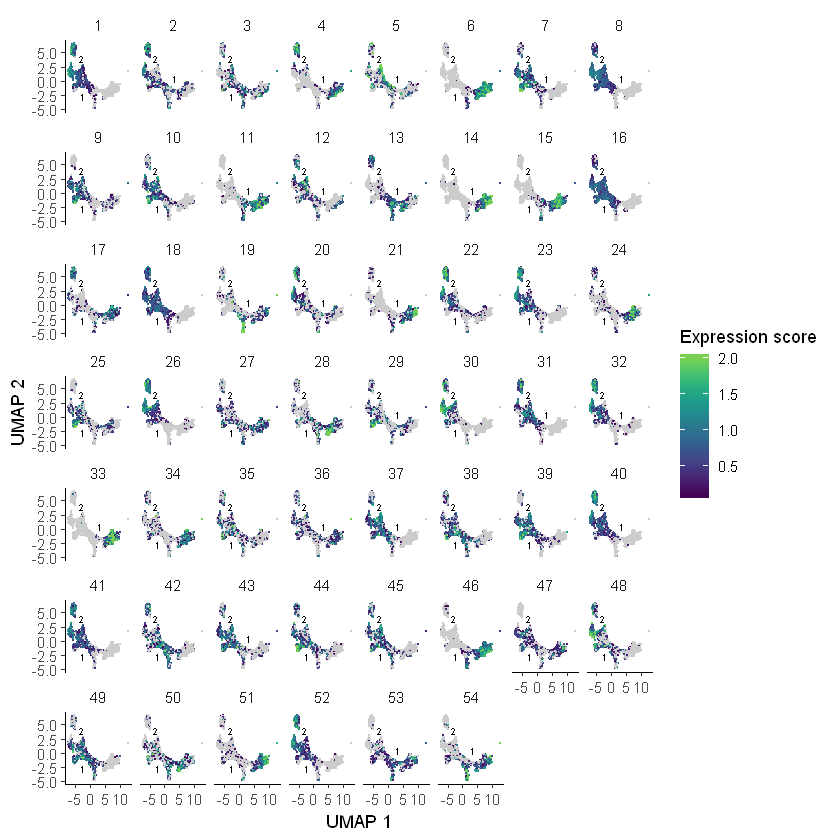

In [15]:
plot_cells(cds,
           genes=gene_module_df,
           group_cells_by="partition",
           color_cells_by="partition",
           show_trajectory_graph=FALSE)

## Find cells sensitive in rotenone

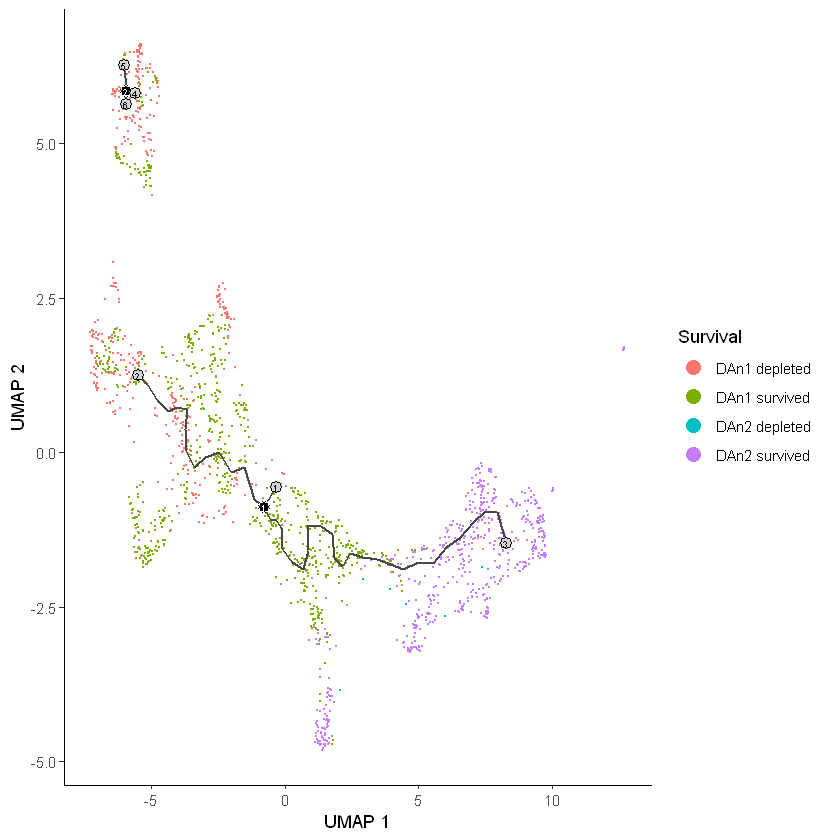

In [16]:

## Get nn relations, choose be stringent choose k 10
nn <- FNN::get.knn(reducedDims(cds)$UMAP,k = 10)$nn.index


## These are DAN1 and DAN2 rotenone graph nodes
nn.rot <- nn[colData(cds)$case %in% c('ROT_DAn1','ROT_DAn2'),]
## Flatten nearest neighbors
nn.rot <- c(nn.rot)
## Remove possible duplicates
nn.rot <- unique(c(nn.rot))


colData(cds)$depleted <- 'depleted'
colData(cds)$depleted[unique(c(nn.rot))] <- 'survived'

colData(cds)$Survival <- with(colData(cds),paste(celltype,depleted))


plot_cells(cds, color_cells_by = 'Survival', label_cell_groups=FALSE)

### Consider only DAn1
- Perform regression
- Find modules

Aligning cells from different batches using Batchelor. 
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091



[1] "Reducing dimensionality"


No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



[1] "Clustering cells"
  |======================================================================| 100%


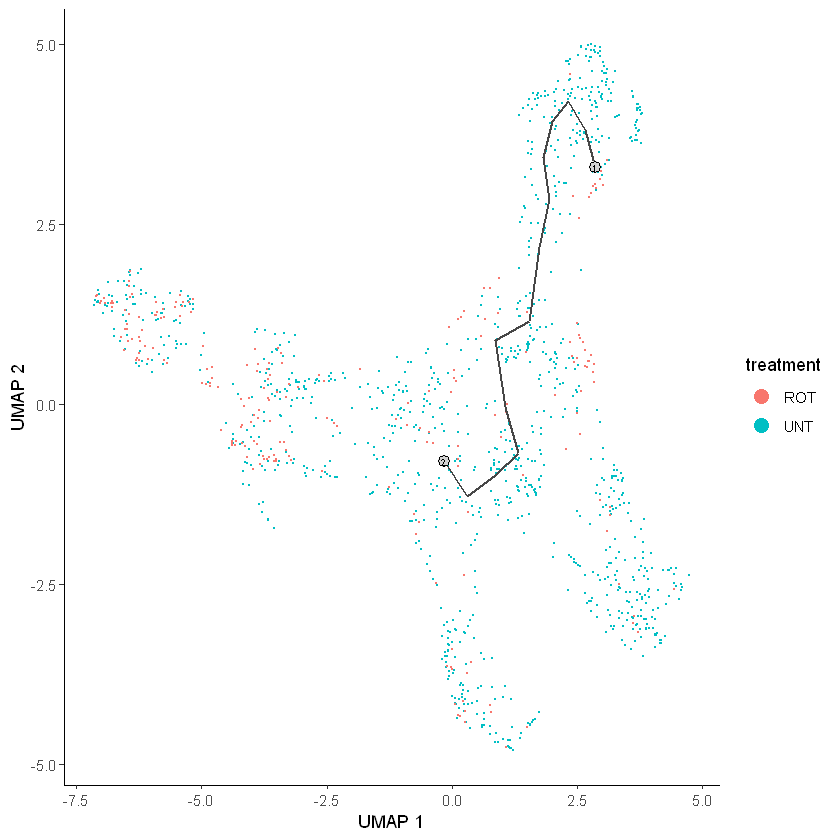

In [17]:
cds.dan1 <- cds.raw[,(colData(cds.raw)$Cell.Type == 'DAn1')]

cds.dan1 <- analyze.raw.regression(cds.dan1)


plot_cells(cds.dan1, color_cells_by = 'treatment', label_cell_groups=FALSE)

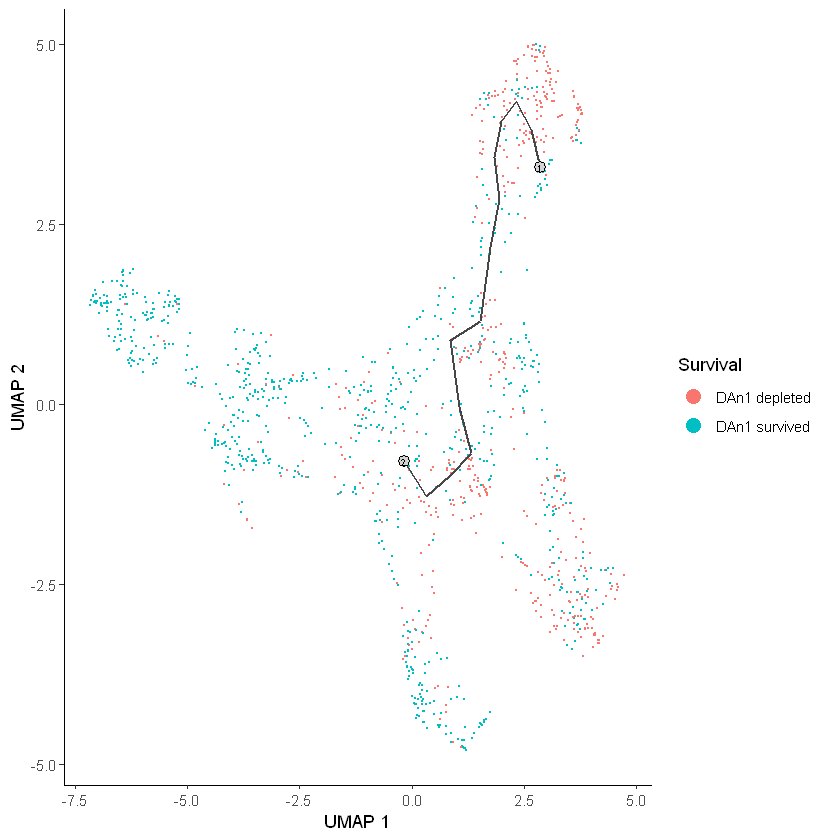

In [18]:
colData(cds.dan1)$Survival <- colData(cds)[colnames(cds.dan1),]$Survival

plot_cells(cds.dan1, color_cells_by = 'Survival', label_cell_groups=FALSE)
#colData(cds)[]


### Consider only DAn1 UNT


In [22]:
library("dplyr")
library("ggplot2")
## Get only the untreated DAn1

cds.dan1.unt <- cds.raw[,(colData(cds.raw)$case == 'UNT_DAn1')]
colData(cds.dan1.unt)$Survival <- colData(cds)[colnames(cds.dan1.unt),]$Survival

cds.dan1.unt <- analyze.raw(cds.dan1.unt)

#ciliated_cds_pr_test_res.dan1.unt <- graph_test(cds.dan1.unt, neighbor_graph="principal_graph", cores=1)
#saveRDS(ciliated_cds_pr_test_res.dan1.unt, paste0(prefix,'_dan1-unt_genes.rds'))
pr_graph_test_res.dan1.unt <- readRDS(paste0(prefix,'_dan1-unt_genes.rds'))

pr_deg_ids.dan1.unt <- row.names(subset(pr_graph_test_res.dan1.unt, q_value < 0.05))


#gene_module_df.dan1.unt <- find_gene_modules(cds.dan1.unt[pr_deg_ids.dan1.unt, ], resolution = 1e-2)
#saveRDS(gene_module_df.dan1.unt, paste0(prefix,'dan1-unt_gene-modules.cds.rds'))
gene_module_df.dan1.unt <- readRDS(paste0(prefix,'dan1-unt_gene-modules.cds.rds'))


c.scores <- t(aggregate_gene_expression(cds.dan1.unt, gene_module_df.dan1.unt))

colnames(c.scores) <- paste0('Module.',colnames(c.scores))
write.csv(c.scores, paste(prefix,'dan1-unt_scores.csv'))


cell_group_df <- with(colData(cds.dan1.unt), tibble::tibble(cell = id, cell_group = Survival))
agg_mat <- aggregate_gene_expression(cds.dan1.unt, gene_module_df.dan1.unt, cell_group_df)

write.csv(agg_mat[order(agg_mat[,2]),], paste0(prefix,'dan1-unt_module-scores.csv'))


[1] "Reducing dimensionality"


No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



[1] "Clustering cells"
  |======================================================================| 100%


36 x 2 sparse Matrix of class "dgCMatrix"
   DAn1 depleted DAn1 survived
17    0.47403973   -0.37128125
2     0.47018438   -0.37021995
6     0.47037496   -0.36932629
26    0.44979573   -0.35364446
30    0.40903251   -0.32577918
7     0.41300569   -0.32437923
21    0.39660878   -0.31082013
19    0.38759008   -0.30420995
25    0.37308657   -0.29643774
22    0.36871903   -0.28814340
15    0.29280030   -0.25482056
16    0.31690038   -0.24795051
36    0.28535672   -0.23325119
28    0.28908198   -0.22855121
18    0.28341973   -0.21963987
14    0.26159797   -0.20600670
9     0.25181868   -0.19576308
4     0.20813930   -0.16286438
35    0.10180125   -0.11102832
23    0.03018976   -0.03221715
20   -0.06074340   -0.02785332
33   -0.03747455   -0.01874848
5    -0.03590824    0.02984826
11   -0.09856176    0.03054957
1    -0.08492660    0.03139687
3    -0.04503492    0.04027459
24   -0.13896352    0.04484241
13   -0.13094698    0.05715046
34   -0.16517021    0.06789356
10   -0.12447820    0.072707

## Consider only DAn1 UNT

In [ ]:



cds.unt <- cds.raw[,rownames(subset(colData(cds.raw), (celltype == 'DAn1') & (treatment == 'UNT')))]
colData(cds.unt)$depleted <- 'DAn1 UNT depleted'
colData(cds.unt)$depleted[which(colnames(cds.unt) %in% rownames(subset(colData(cds), Survival == 'DAn1 survived' )))] <- 'DAn1 UNT survived'
cds.unt <- preprocess_cds(cds.unt, num_dim = 15)

print('Reducing dimensionality')
cds.unt <- reduce_dimension(cds.unt)

print('Clustering cells')
cds.unt <- cluster_cells(cds.unt)


cds.unt <- learn_graph(cds.unt)
#cds <- order_cells(cds)

#cds.unt <- cds.raw[colData(cds)$celltype == 'DAn1' & colData(cds)]

colData(cds.unt)$case <- with(colData(cds.unt), paste0(treatment,'_',celltype))

plot_cells(cds.unt, color_cells_by = 'depleted', label_cell_groups=FALSE)

#ciliated_cds_pr_test_res.unt <- graph_test(cds.unt, neighbor_graph = "principal_graph", cores = 1)
#saveRDS(ciliated_cds_pr_test_res.unt,paste0(prefix,'-unt-dan1_genes.rds'))
#ciliated_cds_pr_test_res.unt <- readRDS(paste0(prefix,'-unt-dan1_genes.rds'))


#saveRDS(cds.unt, paste0(prefix,'dan1.rds'))

In [ ]:
pr_deg_ids.unt <- row.names(subset(ciliated_cds_pr_test_res.unt, q_value < 0.05))

#gene_module_df.unt <- find_gene_modules(cds.unt[pr_deg_ids.unt,], resolution=1e-2)
gene_module_df.unt <- readRDS(paste0(prefix,'-gene-modules.cds.unt.rds'))


cell_group_df.unt <- tibble::tibble(cell=row.names(colData(cds.unt)), 
                                cell_group=colData(cds.unt)$depleted)

#cell_group_df
#partitions(cds)
agg_mat.unt <- aggregate_gene_expression(cds.unt, gene_module_df.unt, cell_group_df.unt)


agg_mat.unt[order(agg_mat.unt[,2]),]

In [ ]:


cell_group_df.unt


In [ ]:
depleted.profile <- c(5,15,12,8,4)
survival.profile <- c(31,25,7,28)
plot_cells(cds.unt, genes=gene_module_df %>% filter(module %in% depleted.profile), show_trajectory_graph=FALSE)

library("dplyr")
library("ggplot2")
gene_module_df_test <- gene_module_df.unt %>%  mutate(score = agg_mat.unt[module,1])

gene_module_df_test <- gene_module_df_test %>%  mutate(module.visual = ifelse(!(module %in% depleted.profile), 0, module ))

ggplot(gene_module_df_test, aes(dim_1, dim_2)) + geom_point(aes(colour = factor(module.visual)))
ggplot(gene_module_df_test, aes(dim_1, dim_2)) + geom_point(aes(colour = factor(module)))

ggplot(gene_module_df_test, aes(dim_1, dim_2)) + geom_point(aes(colour = score))


#write.csv(gene_module_df %>% filter(module %in% depletion.profile.modules), paste0(prefix,'_genes_of_sensitive_rot_population.csv'))

In [ ]:


plot_cells(cds.unt,
           genes=gene_module_df.unt %>% filter(module %in% survival.profile),
           group_cells_by="partition",
           color_cells_by="partition",
           show_trajectory_graph=FALSE)

In [ ]:
write.csv(gene_module_df.unt %>% filter(module %in% depleted.profile),'paper/diffexp/regression-WT-only-dan1-depleted.csv')
write.csv(gene_module_df.unt %>% filter(module %in% survival.profile),'paper/diffexp/regression-WT-only-dan1-resilient.csv')


In [ ]:
c.scores <- t(aggregate_gene_expression(cds.unt, gene_module_df.unt))
colnames(c.scores) <- paste0('Module.',colnames(c.scores))

write.csv(c.scores,paste(prefix,'scores.cds.unt.csv'))

c.scores <- t(aggregate_gene_expression(cds, gene_module_df))
colnames(c.scores) <- paste0('Module.',colnames(c.scores))

write.csv(c.scores, paste(prefix,'scores.cds.csv'))


write.csv(gene_module_df,paste0(prefix,'-gene-modules.cds.csv'), row.names = F)
saveRDS(gene_module_df,paste0(prefix,'-gene-modules.cds.rds'))


write.csv(gene_module_df.unt, paste0(prefix,'-gene-modules.cds.unt.csv'), row.names = F)
saveRDS(gene_module_df.unt, paste0(prefix, '-gene-modules.cds.unt.rds'))

In [ ]:

colData(cds.unt)$UMAP1 <- reducedDims(cds.unt)$UMAP[,1]
colData(cds.unt)$UMAP2 <- reducedDims(cds.unt)$UMAP[,2]
write.csv(colData(cds.unt), paste0(prefix,'-umap.cds.unt.csv'))


#write.csv()

In [ ]:
colData(cds)$UMAP1 <- reducedDims(cds)$UMAP[,1]
colData(cds)$UMAP2 <- reducedDims(cds)$UMAP[,2]
write.csv(colData(cds), paste0(prefix,'-umap.cds.csv'))


colData(cds.unregressed)$UMAP1 <- reducedDims(cds.unregressed)$UMAP[,1]
colData(cds.unregressed)$UMAP2 <- reducedDims(cds.unregressed)$UMAP[,2]
write.csv(colData(cds.unregressed), paste0(prefix,'-umap.cds.unregressed.csv'))

In [ ]:
saveRDS(cds.subset, paste0(prefix, '-cds.subset.rds'))
saveRDS(cds.unt, paste0(prefix, '-cds.unt.dan1.rds'))
saveRDS(cds, paste0(prefix, '-cds.rds'))
saveRDS(cds.unregressed, paste0(prefix, '-cds.unregressed.rds'))

